In [41]:
# Aim is to create a model that can predict the final grade (G3) from the rest of the dataset. 
# ie. G3 is the target label

## **Imports & Constants**

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import warnings # to remove warning when the model is running

from sklearn.model_selection import train_test_split # to split data into train and test sets
from sklearn.linear_model import LogisticRegression # to use Logistic Regression for step of stacking 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier # to use RF and GB as base models + the stacked model
from sklearn.metrics import accuracy_score # to get the accuracy
import matplotlib.pyplot as plt

In [43]:
TARGET = "G3" # the target variable


# ONE_BOUND is the bounding area from the extremes (ie. 1 and -1), to remove the models that are too correlated with the target
# ZERO_BOUND is the bounding area from the middle (ie. 0), to remove the models that are too uncorrelated with the target
ONE_BOUND = 0 ; ZERO_BOUND = 0

TEST_SIZE = 0.2 # percentage of the dataset to be used as a test set

## **The Dataset and Correlation Matrix**

In [44]:
portugeseDF = pd.read_csv('../data/Portuguese.csv')

# This part is copied from "Dataset.ipynb" to get the confusion matrix
le = LabelEncoder()
for col in portugeseDF.select_dtypes(include=['object']).columns:
    portugeseDF[col] = le.fit_transform(portugeseDF[col])
    
correlation_matrix = portugeseDF.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
correlation_matrix = correlation_matrix.mask(mask)

## **Different Models**

In [45]:
# the two base models for the stacking model
randomForestModel = RandomForestClassifier(n_estimators=100, random_state=42)
gradientBoostingModel = GradientBoostingClassifier(n_estimators=100, random_state=42)

# stacking model that uses a 5 fold cross validation scheme (cv)
stackingEnsembleModel = StackingClassifier(estimators=[("random_forest", randomForestModel), ("gradient_boosting", gradientBoostingModel)], final_estimator=LogisticRegression(), cv=5)

## **Functions to Create New Dataset and Run the Models**

In [46]:
def makingNewDataset(correlationMatrix, dataframe):
    orignalAttributes = dict(correlationMatrix.loc[TARGET])
    newAttributes = list()
    removedAttributes = list()

    # iterate through features to choose which to keep
    for key in orignalAttributes:
        if key == TARGET: newAttributes.append(key) # add target to new dataframe
        elif orignalAttributes[key] > ONE_BOUND or orignalAttributes[key] < -(ONE_BOUND): removedAttributes.append(key) # high correlation
        elif orignalAttributes[key] < ZERO_BOUND and orignalAttributes[key] > -(ZERO_BOUND): removedAttributes.append(key) # low correlation
        else: newAttributes.append(key) # add featuers that are in the acceptable range to new dataframe
    
    # make new dataframe
    newData = {}
    for attribute in newAttributes:
        newData[attribute] = dataframe[attribute]
    newPortugeseDF = pd.DataFrame(newData)

    return [newPortugeseDF, newAttributes, removedAttributes] # return new dataframe, list of kept attributes and list of removed attributes

In [47]:
def runTheModel (dataframe, modelName, modelToRun):
    features = dataframe.drop(columns=[TARGET]); target = dataframe[TARGET]
    featureTrain, featureTest, targetTrain, targetTest = train_test_split(features, target, test_size=TEST_SIZE, random_state=42)

    modelToRun.fit(featureTrain, targetTrain)

    testPredictions = modelToRun.predict(featureTest)
    accuracy = accuracy_score(targetTest, testPredictions)
    print(f"{modelName} Accuracy: \t{accuracy * 100:.3f}%")



    plt.figure(figsize=(8, 6))
    plt.scatter(targetTest, testPredictions, alpha=0.6, color='blue')

    # Add a diagonal line for reference (perfect predictions)
    min_val = min(min(targetTest), min(testPredictions))
    max_val = max(max(targetTest), max(testPredictions))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

    # Add labels and title
    plt.title('Prediction vs Actual Values')
    plt.xlabel('Actual G3')
    plt.ylabel('Predicted G3')
    plt.grid(True)
    plt.show()

In [48]:
def run_tests():
    print(f"Correlation values in range: {ONE_BOUND} to {ZERO_BOUND} and -{ZERO_BOUND} to -{ONE_BOUND}\n")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning); warnings.filterwarnings("ignore", category=RuntimeWarning)

        temp=makingNewDataset(correlation_matrix, portugeseDF); newDataset=temp[0]; keptAttributes=temp[1]; removedAttributes=temp[2]
        print(f"List Kept Features:\t\t\t{keptAttributes}"); print(f"List Removed Features:\t\t\t{removedAttributes}")
        print(f"Original / Removed / Kept:\t\t{len(portugeseDF.keys())} / {len(removedAttributes)} / {len(keptAttributes)}")

        runTheModel(newDataset, "\nStacking Ensemble Model", stackingEnsembleModel)

## **Test Section**

Correlation values in range: 1 to 0 and -0 to -1

List Kept Features:			['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
List Removed Features:			[]
Original / Removed / Kept:		33 / 0 / 33

Stacking Ensemble Model Accuracy: 	46.154%


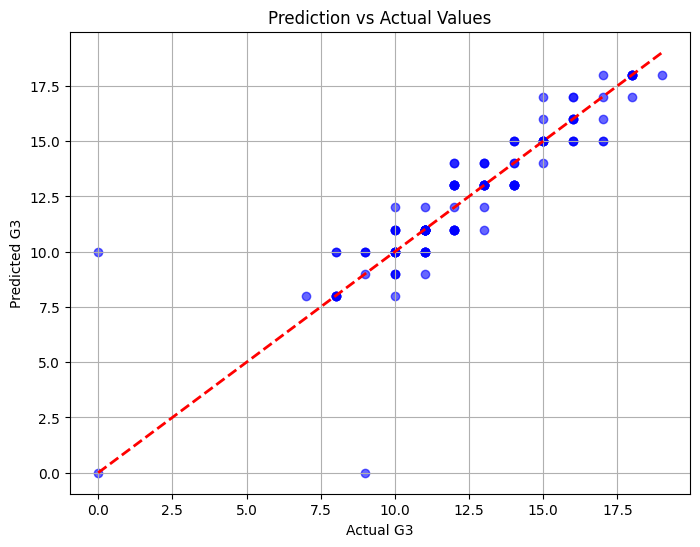

Correlation values in range: 0.8 to 0 and -0 to -0.8

List Kept Features:			['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G3']
List Removed Features:			['G1', 'G2']
Original / Removed / Kept:		33 / 2 / 31

Stacking Ensemble Model Accuracy: 	21.538%


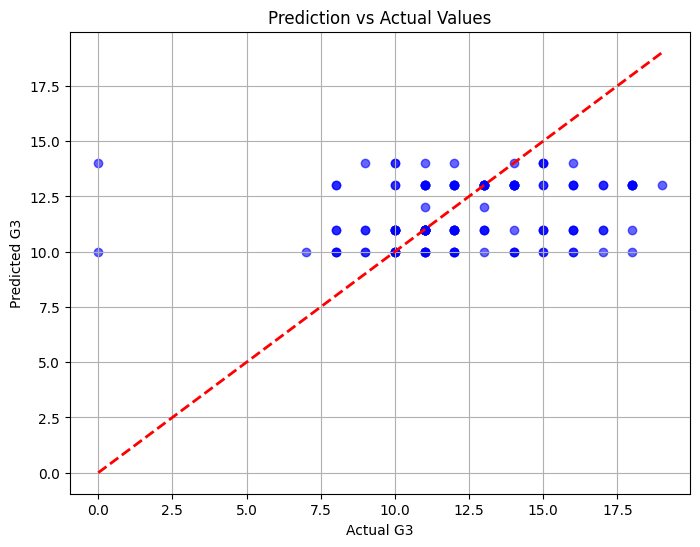

Correlation values in range: 1 to 0.065 and -0.065 to -1

List Kept Features:			['school', 'sex', 'age', 'address', 'Medu', 'Fedu', 'Mjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'higher', 'internet', 'romantic', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
List Removed Features:			['famsize', 'Pstatus', 'Fjob', 'famsup', 'paid', 'activities', 'nursery', 'famrel']
Original / Removed / Kept:		33 / 8 / 25

Stacking Ensemble Model Accuracy: 	48.462%


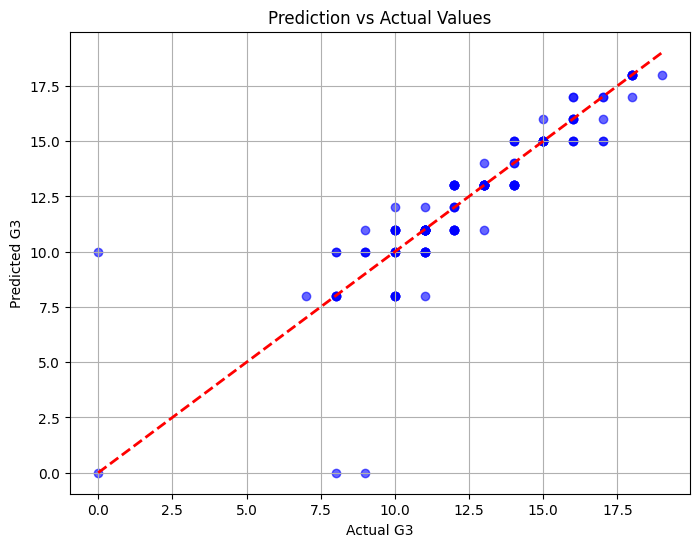

Correlation values in range: 0.8 to 0.065 and -0.065 to -0.8

List Kept Features:			['school', 'sex', 'age', 'address', 'Medu', 'Fedu', 'Mjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'higher', 'internet', 'romantic', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G3']
List Removed Features:			['famsize', 'Pstatus', 'Fjob', 'famsup', 'paid', 'activities', 'nursery', 'famrel', 'G1', 'G2']
Original / Removed / Kept:		33 / 10 / 23

Stacking Ensemble Model Accuracy: 	23.846%


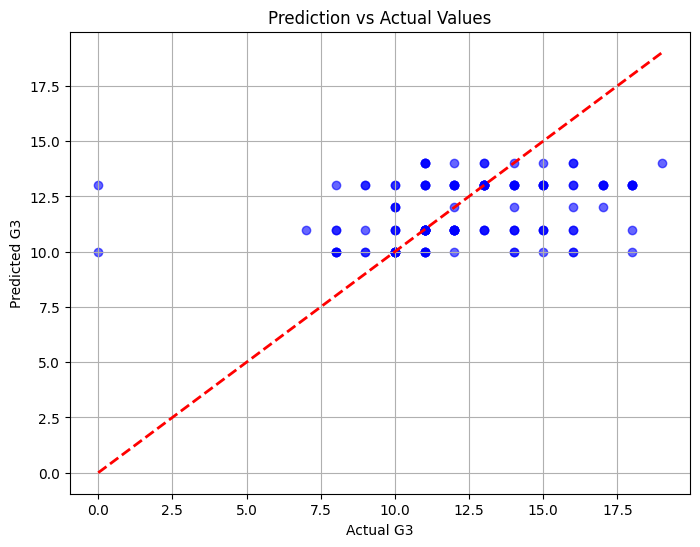

In [51]:
# == All Features ==
ONE_BOUND = 1 ; ZERO_BOUND = 0
run_tests()

# == No High Correlation Features ==
ONE_BOUND = 0.8 ; ZERO_BOUND = 0 
run_tests()

# == No Low Correlation Features ==
ONE_BOUND = 1 ; ZERO_BOUND = 0.065 
run_tests()

# == No High and Low Correlation Features ==
ONE_BOUND = 0.8 ; ZERO_BOUND = 0.065 
run_tests()